In [131]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from my_script import log_value,run_myradex_of,mol_data
from scipy.constants import h,k,c
from astroquery.ipac.ned import Ned

In [2]:
RBGS_basic=np.loadtxt('references/RBGS.csv',delimiter=',',dtype=str)
sample_info=np.loadtxt('references/total_info_v2.csv',delimiter=',',dtype=str)
basic_info=sample_info
sample_cor,RBGS_cor=[],[]
for i in range(1,len(sample_info)):
    ra,dec=sample_info[i,1:3]
    sample_cor.append(SkyCoord(ra,dec,frame="icrs",unit=(u.hourangle, u.deg)))
for i in range(len(RBGS_basic)):
    ra=RBGS_basic[i,4].strip().replace(' ',':')
    dec=RBGS_basic[i,5].strip().replace(' ',':')
    RBGS_cor.append(SkyCoord(ra,dec,frame="icrs",unit=(u.hourangle, u.deg))) 
def read_distance(sourcename):
    idx=np.where(basic_info[:,0]==sourcename)[0][0]
    d,r=float(basic_info[idx,4]),float(basic_info[idx,3])
    if not np.isnan(d):
        distance=d
    else:
        distance=r*c/1e3/67.8
    return distance
def read_redshift(sourcename):
    idx=np.where(basic_info[:,0]==sourcename)[0][0]
    d,r=float(basic_info[idx,4]),float(basic_info[idx,3])
    if not np.isnan(r):
        redshift=r
    else:
        redshift=d*67.8/c*1e3
    return redshift

In [3]:
idx_in_RBGS=np.zeros(len(sample_info)-1)
idx_in_RBGS[:]=np.nan
for i in range(1,len(sample_info)):
    targcor=sample_cor[i-1]
    sep=np.zeros(len(RBGS_basic))
    for j in range(len(RBGS_basic)):
        sep[j]=targcor.separation(RBGS_cor[j]).deg
    idx=np.argmin(sep)
    if sep[idx]<1/60:
        idx_in_RBGS[i-1]=idx

In [4]:
RBGS_basic[:,22]

array(['  59.62', '  77.60', '   3.10', ' 105.76', '  15.90', '  35.31',
       '  16.20', '  21.92', '  81.20', '  47.28', '   0.79', '  79.23',
       '   3.10', '   3.10', '  11.45', '  21.60', '  64.28', '   0.06',
       '  60.71', '   2.00', '  70.30', '  21.59', '  78.57', ' 136.17',
       '  90.96', '  31.12', ' 122.02', '  33.16', '  30.22', '   0.84',
       '  14.98', '  63.37', '   4.46', '   9.99', '  67.88', ' 188.37',
       '  54.59', '  12.33', ' 106.96', '  21.21', ' 126.70', '  40.81',
       '  19.87', '  59.02', '  73.48', '  63.96', '  28.71', '  49.33',
       '  52.90', '  70.37', '  50.13', '  51.10', '  61.48', ' 117.29',
       '  52.45', '  50.29', '   8.57', ' 131.71', '  15.75', '  61.97',
       '  40.57', '   9.16', '  76.36', '  20.65', '  26.43', '  53.83',
       '  19.33', '  11.31', '  51.32', '  21.33', '  13.70', '  53.46',
       '  18.61', '  83.37', '  90.66', '  20.05', '  16.80', '  47.41',
       ' 121.94', '  53.78', '   6.96', '  47.70', 

In [18]:
lg_LTIR=np.zeros(len(idx_in_RBGS))
for i in range(len(idx_in_RBGS)):
    if not np.isnan(idx_in_RBGS[i]):
        idx=int(idx_in_RBGS[i])
        dist_RBGS=float(RBGS_basic[idx,22])
        TIR_RBGS=float(RBGS_basic[idx,25].replace(':',''))
        lg_LTIR[i]=TIR_RBGS-np.log10(dist_RBGS**2)+np.log10(read_distance(basic_info[i+1,0])**2)

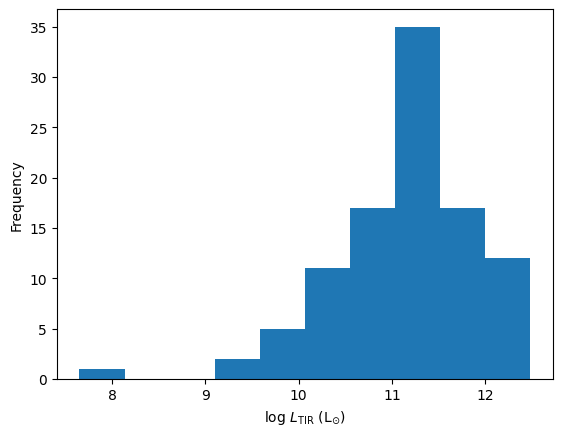

In [40]:
lg_LTIR[lg_LTIR==0]=np.nan
plt.figure()
plt.hist(lg_LTIR)
plt.xlabel(r'log $L_{\rm TIR}~\rm (L_{\odot})$')
plt.ylabel('Frequency')
plt.savefig('plots/sample_dist/TIR_dist.pdf')

In [27]:
np.nanargmin(lg_LTIR)
basic_info[62]

array(['NGC4569', '12:36:49.80', '+13:09:46.0', 'nan', '1', 'NGC4569'],
      dtype='<U16')

In [28]:
lg_LCO10=np.zeros([len(sample_info)-1,2])
co_mol=mol_data('/home/zj/Documents/radex_mol/','co.dat')
typCOTb=run_myradex_of(Tkin=35,nH2=1e4,abundance_Kvir=1e-4,molecule=co_mol,Tbg=2.73)[0]
COr21=typCOTb[1]/typCOTb[0]
basic_info=sample_info

def load_mol(molname,data):
    idx=np.where(data[0]==molname)[0][0]
    nline=len(np.where(data[1:,idx+1]!='')[0])
    Jup=np.arange(nline)+1
    SED=data[Jup,idx:idx+3].astype(float)
    return SED
def line_flux_lum(flux,frequency,redshift,distance):
    alpha=3.25e7/(frequency/1e9/(1+redshift))**2*distance**2/(1+redshift)**3
    lum=flux*np.array([alpha]).T
    return lum
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    data=np.loadtxt('beam_matched_flux/%s.csv'%sourcename.replace(' ',''),delimiter=',',dtype=str)
    distance=read_distance(sourcename)
    redshift=read_redshift(sourcename)
    CO_SLED=load_mol('CO Jup',data)
    CO_Jup=CO_SLED[:,0].astype(int)
    detJ=CO_Jup[~np.isnan(CO_SLED).any(axis=1)]
    if len(detJ)==0 or min(detJ)>2:
        continue
    if min(detJ)==1:    
        lum=line_flux_lum(CO_SLED[:,1:3],co_mol.rad_data[CO_Jup-1,3],redshift,distance)
        lg_LCO10[i-1]=log_value(lum[min(detJ)-1])
    elif min(detJ)==2:
        lum=line_flux_lum(CO_SLED[:,1:3],co_mol.rad_data[CO_Jup-1,3],redshift,distance)
        lg_LCO10[i-1]=log_value(lum[min(detJ)-1]*COr21)
lg_LCO10[lg_LCO10==0]=np.nan

/home/zj/.local/lib/python3.8/site-packages/my_script.py:228: RuntimeWarning: divide by zero encountered in log10
  lg_value[0]=np.log10(value[0])
/home/zj/.local/lib/python3.8/site-packages/my_script.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  lg_value[1]=value[1]/value[0]/np.log(10)


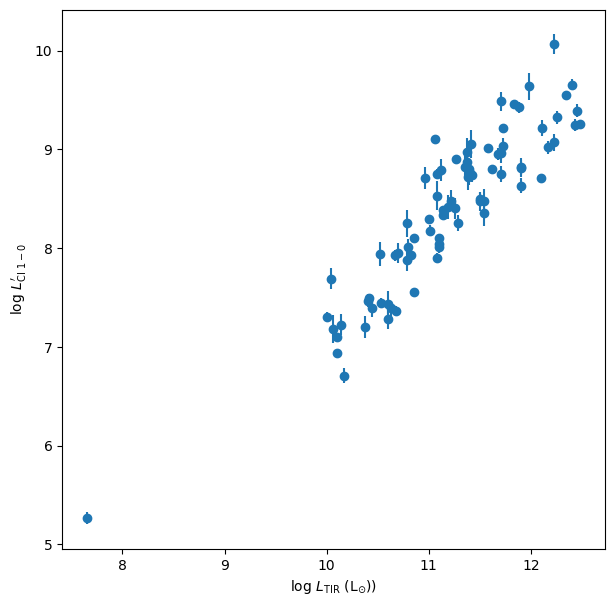

In [46]:
plt.figure(figsize=[7,7])
plt.errorbar(lg_LTIR,lg_LCI10[:,0],yerr=lg_LCI10[:,1],fmt='o')
plt.xlabel(r'log $L_{\rm TIR}~\rm (L_{\odot})$)')
plt.ylabel(r'log $L^\prime_{\rm CI~1-0}$')
plt.savefig('plots/sample_dist/TIR_CI10.pdf')

In [45]:
ci_mol=mol_data('/home/zj/Documents/radex_mol/','catom.dat')
lg_LCI10=np.zeros([len(sample_info)-1,2])
for i in range(1,len(basic_info)):
    sourcename=basic_info[i,0]
    data=np.loadtxt('beam_matched_flux/%s.csv'%sourcename.replace(' ',''),delimiter=',',dtype=str)
    distance=read_distance(sourcename)
    redshift=read_redshift(sourcename)
    CI_SLED=load_mol('CI Jup',data)
    CI_Jup=CI_SLED[:,0].astype(int)
    CI_SLED[CI_SLED[:,2]/CI_SLED[:,1]>1/3]=np.nan
    detJ=CI_Jup[~np.isnan(CI_SLED).any(axis=1)]
    CI_lum=np.zeros_like(CI_SLED)
    CI_lum[:,0]=CI_SLED[:,0]
    CI_lum[:,1:3]=line_flux_lum(CI_SLED[CI_Jup-1,1:3],ci_mol.rad_data[CI_Jup-1,3],redshift,distance)
    lg_LCI10[i-1]=log_value(CI_lum[0,1:3])
lg_LCI10

array([[8.29349242e+00, 9.71422825e-03],
       [9.21592699e+00, 2.98652206e-02],
       [8.80370668e+00, 6.83682994e-02],
       [8.73049334e+00, 9.39979548e-02],
       [8.75197366e+00, 8.11448408e-02],
       [9.65338007e+00, 5.60214904e-02],
       [           nan,            nan],
       [8.70905641e+00, 1.09328169e-01],
       [           nan,            nan],
       [           nan,            nan],
       [9.55063503e+00, 1.80383665e-02],
       [8.87708801e+00, 1.34079785e-01],
       [8.48058684e+00, 1.06199927e-01],
       [           nan,            nan],
       [8.74965275e+00, 5.35618198e-02],
       [8.82014172e+00, 1.13418752e-01],
       [8.60698350e+00, 1.40198931e-01],
       [           nan,            nan],
       [9.45701634e+00, 2.13766387e-02],
       [8.47481034e+00, 9.61813645e-02],
       [8.75879695e+00, 4.40214040e-02],
       [9.10775049e+00, 2.95546547e-02],
       [9.02913380e+00, 8.15992387e-02],
       [9.01489643e+00, 3.55928069e-02],
       [8.794532

In [77]:
def match_str_list(tstr,olist):
    result=[]
    for i in range(len(olist)):
        if olist[i].strip()==tstr.strip():
            result.append(i)
    return result
lumtable=np.loadtxt('references/Liu16_luminosity.csv',delimiter=',',dtype=str)
destable=np.loadtxt('references/Liu16_surden.csv',delimiter=',',dtype=str)
lumtable=np.char.strip(lumtable)
destable=np.char.strip(destable)

Text(0, 0.5, 'log $\\Sigma_{\\rm SFR\\_IR}~\\rm (M_{\\odot}yr^{-1}kpc^{-2})$')

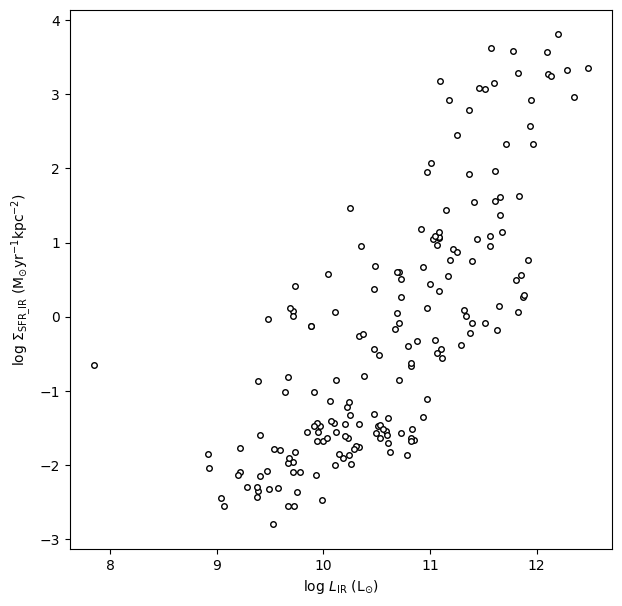

In [91]:
plt.figure(figsize=[7,7])
plt.errorbar(lumtable[1:,5].astype(float),destable[1:,8].astype(float),fmt='o', ecolor='b',elinewidth=1,ms=4,mfc="w",mec='k',capthick=1,capsize=3)
plt.xlabel(r'log $L_{\rm IR}~\rm (L_{\odot})$')
plt.ylabel(r'log $\Sigma_{\rm SFR\_IR}~\rm (M_{\odot}yr^{-1}kpc^{-2})$')

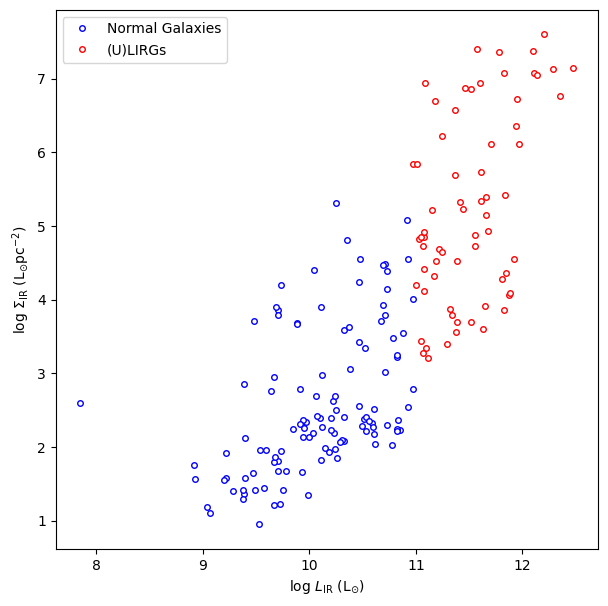

In [188]:
ngidx=lumtable[1:,0]=='Normal Galaxies'
ulidx=lumtable[1:,0]=='(U)LIRGs'
lgIR=lumtable[1:,5].astype(float)
Distance=lumtable[1:,2].astype(float)
Diameter=np.zeros(len(destable)-1)
for i in range(1,len(destable)):
    dia=destable[i,2]
    dialist=dia.split('+')
    if len(dialist)==1:
        Diameter[i-1]=float(dialist[0])
    elif len(dialist)==2:
        Diameter[i-1]=np.sqrt(float(dialist[0])**2+float(dialist[1])**2)
size=Diameter*Distance*1e6*np.pi/180/3600
area=np.pi*size**2 /2
SigmaIR=lgIR-np.log10(area)
plt.figure(figsize=[7,7])
plt.errorbar(lgIR[ngidx],SigmaIR[ngidx],fmt='o', ecolor='b',elinewidth=1,ms=4,mfc="w",mec='b',capthick=1,capsize=3,label='Normal Galaxies')
plt.errorbar(lgIR[ulidx],SigmaIR[ulidx],fmt='o', ecolor='b',elinewidth=1,ms=4,mfc="w",mec='r',capthick=1,capsize=3,label='(U)LIRGs')
plt.legend()
plt.xlabel(r'log $L_{\rm IR}~\rm (L_{\odot})$')
plt.ylabel(r'log $\Sigma_{\rm IR}~\rm (L_{\odot}pc^{-2})$')
plt.savefig('plots/sample_dist/TIR_SigmaTIR.pdf')

In [145]:
Liu_cor=[]
for i in range(1,len(lumtable)):
    nedtable=Ned.query_object(lumtable[i,1])
    Liu_cor.append(SkyCoord(nedtable[0]['RA'],nedtable[0]['DEC'],frame="icrs",unit=(u.deg, u.deg)))

In [159]:
idx_in_Liu=np.zeros(len(sample_info)-1)
idx_in_Liu[:]=np.nan
for i in range(1,len(sample_info)):
    targcor=sample_cor[i-1]
    sep=np.zeros(len(Liu_cor))
    for j in range(len(Liu_cor)):
        sep[j]=targcor.separation(Liu_cor[j]).deg
    idx=np.argmin(sep)
    if sep[idx]<1/60:
        idx_in_Liu[i-1]=idx

In [163]:
sample_dia=np.zeros(len(sample_info)-1)
sample_dia[:]=np.nan
for i in range(len(idx_in_Liu)):
    if np.isnan(idx_in_Liu[i]):
          continue
    dialist=destable[int(idx_in_Liu[i])+1,2].split('+')
    if len(dialist)==1:
        sample_dia[i]=float(dialist[0])
    elif len(dialist)==2:
        sample_dia[i]=np.sqrt(float(dialist[0])**2+float(dialist[1])**2)

In [172]:
data=np.char.strip(np.loadtxt('references/basic_info.csv',delimiter=',',dtype=str))
idx=np.where(data[0]=='Size / “')[0][0]
apexsam_dia=np.loadtxt('references/basic_info.csv',delimiter=',',dtype=str)[1:,idx].astype(float)
for i in range(26):
    if np.isnan(sample_dia[i]):
        sample_dia[i]=apexsam_dia[i]

In [187]:
#np.savetxt('references/total_info_v2.csv',sample_info,delimiter=',',fmt='%s')
#basic_info=np.loadtxt('references/total_info_v2.csv',delimiter=',',dtype=str)
#newcol=np.concatenate([['Size/arcsec'],sample_dia])
#basic_info_new=np.concatenate([basic_info,np.array([newcol]).T],axis=1)
#np.savetxt('references/total_info_v2_new.csv',basic_info_new,delimiter=',',fmt='%s')

In [189]:
np.pi/4/np.log(2)

1.1330900354567985